# Import packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, confusion_matrix, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
import numpy as np
import time
import random
import math
from sklearn.metrics import silhouette_score
import torch.nn.init as init
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import os
from tqdm import tqdm
from torch.utils.data import TensorDataset
import torch.nn.functional as F


#Set seeds
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#For data interpolation
BICUBIC = InterpolationMode.BICUBIC
def _convert_image_to_rgb(image):
    return image.convert("RGB")

In [ ]:
pip install git+https://github.com/openai/CLIP.git  #Install CLIP

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xhz49gff
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xhz49gff
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import clip

# Data augmentation code: We only use GaussianBlur and RandomCrop for data augmentation. The code below generates two views of an image by randomly selecting and applying either GaussianBlur or RandomCrop.

In [ ]:
from PIL import ImageFilter
import random


class RandomSelectTransform:
    def __init__(self, preprocess, *transforms):
        self.preprocess = preprocess
        self.transforms = transforms

    def __call__(self, x):
        x = self.preprocess(x)
        transform = random.choice(self.transforms)
        return transform(x)

class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]



class GaussianBlur(object):
    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma
    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x


In [ ]:
#This preprocess follows TAC's setting.
preprocess = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(224, interpolation=BICUBIC),
                torchvision.transforms.CenterCrop(224),
                _convert_image_to_rgb,
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    (0.48145466, 0.4578275, 0.40821073),
                    (0.26862954, 0.26130258, 0.27577711),
                ),
            ]
        )

combined_transform = RandomSelectTransform(
    preprocess,
    transforms.RandomCrop(224, padding=4),# Random Crops
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))  # Gaussian blur
)
final_transform = TwoCropsTransform(combined_transform)

# Load the dataset

In [ ]:
#load in dataset if CIFAR10
# train = datasets.CIFAR10(root='./data', train=True, download=True, transform=final_transform)
# test = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)




#If it's CIFAR-20, please uncomment the code below to transfer from CIFAR-100.
# cifar100_to_cifar20 = {0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3,
#                        10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9,
#                        18: 7, 19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6,
#                        26: 13, 27: 15, 28: 3, 29: 15, 30: 0, 31: 11, 32: 1, 33: 10,
#                        34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5, 40: 5, 41: 19,
#                        42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17, 48: 18, 49: 10,
#                        50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0, 56: 17, 57: 4,
#                        58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12, 64: 12, 65: 16,
#                        66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0, 73: 1,
#                        74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19,
#                        82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19,
#                        90: 18, 91: 1, 92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8,
#                        98: 14, 99: 13}

# class CIFAR20(datasets.CIFAR100):
#     def __init__(self, root, train=True, transform=None, download=False):
#         super().__init__(root, train=train, transform=transform, download=download)
#         self.targets = [cifar100_to_cifar20[label] for label in self.targets]

# train = CIFAR20(root='./data', train=True, download=True, transform=final_transform)
# test = CIFAR20(root='./data', train=False, download=True, transform=preprocess)








# If it's STL-10, please uncomment the code below to download.
train = datasets.STL10(root='./data', split='train', download=True, transform=final_transform)
test = datasets.STL10(root='./data', split='test', download=True, transform=preprocess)


#Imagenet-10 and dogs datsets can be found in TAC


100%|██████████| 2.64G/2.64G [12:24<00:00, 3.55MB/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
text = {'A photo of a dog','A photo of a airplane','A photo of a automobile','A photo of a bird','A photo of a cat','A photo of a deer','A photo of a frog','A photo of a horse','A photo of a ship','A photo of a truck'}

# Use below for Dino

In [ ]:
# model = torch.hub.load("facebookresearch/dino:main", "dino_vitb8", pretrained=True)
# model.to(device)
# model.eval()


# def dino_encode_images(model, images):
#     with torch.no_grad():
#         out = model.get_intermediate_layers(images, n=1)
#         cls_emb = out[0][:, 0, :]
#         return cls_emb

# def get_features_train(dataset):
#     all_features_q = []
#     all_features_k = []
#     all_labels = []

#     with torch.no_grad():
#         for (images_q, images_k), labels in tqdm(DataLoader(dataset, batch_size=256)):
#             images_q = images_q.to(device)
#             images_k = images_k.to(device)
#             features_q = dino_encode_images(model, images_q)
#             features_k = dino_encode_images(model, images_k)

#             all_features_q.append(features_q.cpu())
#             all_features_k.append(features_k.cpu())
#             all_labels.append(labels)

#     return torch.cat(all_features_q), torch.cat(all_features_k), torch.cat(all_labels)



# def get_features_test(dataset):
#     all_features, all_labels = [], []
#     loader = DataLoader(dataset, batch_size=256, shuffle=False)
#     for images, labels in tqdm(loader):
#         images = images.to(device)
#         features = dino_encode_images(model, images)
#         all_features.append(features.cpu())
#         all_labels.append(labels)
#     return torch.cat(all_features), torch.cat(all_labels)

Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_vitbase8_pretrain.pth
100%|██████████| 327M/327M [00:01<00:00, 228MB/s]


# if Use CLIP

In [ ]:
# Load the CLIP model
model,_ = clip.load('ViT-B/32', device)


def get_features_train(dataset):
    all_features_q = []
    all_features_k = []
    all_labels = []

    with torch.no_grad():
        for (images_q, images_k), labels in tqdm(DataLoader(dataset, batch_size=256)):
            images_q = images_q.to(device)
            images_k = images_k.to(device)
            features_q = model.encode_image(images_q)
            features_k = model.encode_image(images_k)

            all_features_q.append(features_q.cpu())
            all_features_k.append(features_k.cpu())
            all_labels.append(labels)

    return torch.cat(all_features_q), torch.cat(all_features_k), torch.cat(all_labels)


def get_features_test(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=256)):
            images = images.to(device)
            features = model.encode_image(images)

            all_features.append(features.cpu())
            all_labels.append(labels)

    return torch.cat(all_features), torch.cat(all_labels)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 53.3MiB/s]


# Get features from the pre-trained model. This is the most time-consuming part for our model. It will take some time so please use GPU.

In [ ]:
train_features_q, train_features_k, train_labels = get_features_train(train)
test_features, test_labels = get_features_test(test)

100%|██████████| 32/32 [00:15<00:00,  2.07it/s]


# Then we need to scale/normalize the features into (0,1) to fit the MLP. I have tried different ways but the below one is the best among them.

In [ ]:
train_min_q = train_features_q.min(dim=0, keepdim=True).values
train_max_q = train_features_q.max(dim=0, keepdim=True).values

train_min_k = train_features_k.min(dim=0, keepdim=True).values
train_max_k = train_features_k.max(dim=0, keepdim=True).values


train_features_q_3 = ((train_features_q - train_min_q) / (train_max_q - train_min_q + 1e-8))
train_features_k_3 = ((train_features_k - train_min_k) / (train_max_k - train_min_k + 1e-8))


test_features_tensor_3 = ((test_features - train_min_q) / (train_max_k - train_min_k + 1e-8))


train_features_q_3 = train_features_q_3.float()
train_features_k_3 = train_features_k_3.float()
test_features_tensor_3 = test_features_tensor_3.float()

# train_dataset = TensorDataset(train_features_q_3, train_features_k_3, train_labels) #We dont need train-labels for now
train_dataset = TensorDataset(train_features_q_3, train_features_k_3)
test_dataset = TensorDataset(test_features_tensor_3, test_labels)

# Define the cluster head:

# Please determine the k first, here we set it as 10

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, cluster_num=10):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.cluster_num = cluster_num

        # Encoder part
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 786),
            nn.BatchNorm1d(786),
            nn.ReLU(),
            nn.Linear(786, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, self.cluster_num),
            nn.Softmax(dim=1)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.trunc_normal_(m.weight, std=0.02)
                # init.trunc_normal_(m.weight, std=0.01) #If dino


    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

# Pack the train loader up

In [ ]:
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# This is the class for evaluating ACC, ARI,NMI

In [ ]:
class ClusterEval():
    def __init__(self, data, clu_labels, labels = None):
        ### init function
        ### @params data : numpy.array source data
        ### @params clu_labels : numpy.array cluster labels
        ### @params labels : source labels, if no labels available, None
        self.data = data
        self.clu_labels = clu_labels
        self.labels = labels

        self.n_data = data.shape[0]                   # data number
        self.n_clusters = len(np.unique(clu_labels))  # the number of clusters
        if isinstance(labels, np.ndarray):
            self.n_classes = len(np.unique(labels))   # real class number

        self.centers = self.calc_centers()            # find centers

        self.CP = self.compactness()
        self.SP = self.separation()

        self.labels_grid = self.calc_labels_grid()   # labels fusion matrix
        self.norm_labels_grid = self.labels_grid / np.sum(self.labels_grid, axis = 1).reshape(-1, 1)    # normlize

        self.RI = self.rand_index()
        self.ARI = self.adjust_rand_index()
        self.MR = self.mis_c()
        self.NMI = self.normalized_mutual_info()

    def calc_centers(self):
        ### calculate centers using clu_labels and data
        ### @return numpy.array
        centers = []
        for k in range(self.n_clusters):
            centers.append(np.mean(self.data[self.clu_labels == k, :]))
        centers = np.array(centers)
        print(centers.shape)
        return centers

    def compactness(self):
        ### compute the target function, eval inner-cluster distance
        ### the lower the better
        CP = 0.0
        for k in range(self.n_clusters):
            indexes = np.array(range(self.n_data))[self.clu_labels == k]
            clu_data = self.data[indexes, :]
            center = self.centers[k]
            CP += np.mean(np.sum(np.square(clu_data - center.reshape(1, -1)), axis = 1))
        return CP

    def separation(self):
        ### compute the between-cluster distance
        ### the higher the better
        SP = 0.0
        for k in range(self.n_clusters):
            dis2 = np.sum(np.square(self.centers - self.centers[k].reshape(1, -1)), axis = 1)
            SP += np.sum(np.sqrt(dis2))
        SP = 2 * SP / (self.n_clusters * (self.n_clusters - 1))
        return SP

    def calc_labels_grid(self):
        ### labels available, compute labels fusion matrix
        ### row-axis is cluster labels, col-axis is real labels
        if not isinstance(self.labels, np.ndarray):
            return None
        grid = np.zeros((self.n_clusters, self.n_clusters))
        for k in range(self.n_clusters):
            indexes = np.array(range(self.n_data))[self.clu_labels == k]
            real_labels = self.labels[indexes]
            for j in range(self.n_classes):
                grid[k][j] = np.sum(real_labels == j)
        return grid

    def mis_c(self):
      cost_matrix = confusion_matrix(self.labels, self.clu_labels)
      row_ind, col_ind = linear_sum_assignment(-cost_matrix)
      correct_classifications = cost_matrix[row_ind, col_ind].sum()
      MR = 1 - correct_classifications / len(self.labels)
      return MR

    def rand_index(self):
        ### labels available, rand index
        ### the higher the better
        if not isinstance(self.labels, np.ndarray):
            return None
        # brute force, for every pair
        #tp = 0    # true positive, same cluster clustered in the same cluster
        #tn = 0    # true negative, different cluster clustered in the different cluster
        #for i in range(self.n_data):
        #    for j in range(self.n_data):
        #        if self.labels[i] == self.labels[j] and self.clu_labels[i] == self.clu_labels[j]:
        #            tp += 1
        #        if self.labels[i] != self.labels[j] and self.clu_labels[i] != self.clu_labels[j]:
        #            tn += 1
        #RI = 2.0 * (tp + tn)/(self.n_data * (self.n_data - 1))

        RI = 0.0
        for i in range(self.n_clusters):
            for j in range(self.n_classes):
                a = self.labels_grid[i][j]
                RI += a * (a - 1) / 2
        RI = RI / (self.n_data * (self.n_data - 1))
        return RI

    def adjust_rand_index(self):
        ### labels available, adjust rand index
        ### ARI = (RI - E[RI]) / (MaxRI -E[RI])
        ### the higher the better
        if not isinstance(self.labels, np.ndarray):
            return None
        sum_labels = np.sum(self.labels_grid, axis = 0)       # sum by col
        sum_clu_labels = np.sum(self.labels_grid, axis = 1)   # sum by row

        Index = 0                  # RI
        ExpectedIndex = 0          # E[RI]
        MaxIndex = 0               # MaxRI

        # calculate RI
        for i in range(self.n_clusters):
            for j in range(self.n_classes):
                a = self.labels_grid[i][j]
                Index += a * (a - 1)/2

        # calculate E[RI] and MaxRI
        sum_a = sum([x * (x - 1) / 2 for x in sum_labels])
        sum_b = sum([x * (x - 1) / 2 for x in sum_clu_labels])
        ExpectedIndex = 2 * sum_a * sum_b / (self.n_data * (self.n_data - 1))
        MaxIndex = (sum_a + sum_b) / 2

        ARI = (Index - ExpectedIndex) / (MaxIndex - ExpectedIndex)
        return ARI

    def normalized_mutual_info(self):
        ### labels available, compute normalized mutual information
        ### the higher the better
        if not isinstance(self.labels, np.ndarray):
            return None
        NMI = normalized_mutual_info_score(self.labels, self.clu_labels)
        return NMI

In [ ]:
def evaluate_clustering(model, test_loader, num_clusters, labels):
    model.eval()

    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels_batch in test_loader:
            images = images.view(images.size(0), -1).to(device)
            features = model.encoder(images)
            all_features.append(features.cpu().numpy())
            all_labels.append(labels_batch.cpu().numpy())


    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)


    cluster_labels = np.argmax(all_features, axis=1)


    eval_obj = ClusterEval(all_features, cluster_labels, labels=all_labels)
    print(f"ACC: {1 - eval_obj.MR:.4f}, ARI: {eval_obj.ARI:.4f}, NMI: {eval_obj.NMI:.4f}")

# These are our losses:

In [ ]:
def cosine_distance(x1, x2):

    dot_product = torch.matmul(x1, x2.T)
    norm_x1 = torch.norm(x1, dim=1, keepdim=True)
    norm_x2 = torch.norm(x2, dim=1, keepdim=True)
    norm_product = torch.matmul(norm_x1, norm_x2.T)
    cos_sim = dot_product / norm_product
    return 1 - cos_sim

In [ ]:
def confidence_loss(p, q):


    dot_product = torch.sum(p * q, dim=1)
    log_dot_product = torch.log(dot_product + 1e-8)


    loss = -torch.mean(log_dot_product)
    return loss


In [ ]:
def cosine_similarity_loss(x1, x2):
    cos = F.cosine_similarity(x1, x2, dim=1)
    loss = 1 - cos.mean()
    return loss

In [ ]:
def balance_loss(p, q):

    mean_p = torch.mean(p, dim=0)
    mean_q = torch.mean(q, dim=0)

    entropy_p = -torch.sum(mean_p * torch.log(mean_p + 1e-8))
    entropy_q = -torch.sum(mean_q * torch.log(mean_q + 1e-8))

    balance_loss = entropy_p + entropy_q
    return balance_loss

In [ ]:
cross_entropy_loss = nn.CrossEntropyLoss()

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=8000, shuffle=True)  #For STL-10 dataset

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=True)

In [ ]:
AE = AutoEncoder(512).to(device)

optimizer_AE = optim.Adam(AE.parameters(), lr=0.001)
epochs = 30
scheduler_AE = optim.lr_scheduler.CosineAnnealingLR(optimizer_AE, T_max=epochs, eta_min=0.00001)


for epoch in range(epochs):
    epoch_loss = 0.0
    total_conl =0
    total_cel =0
    total_bal =0

    AE.train()
    for images_q, images_k in train_loader:
        images_q = images_q.view(images_q.size(0), -1).to(device)
        images_k = images_k.view(images_q.size(0), -1).to(device)

        optimizer_AE.zero_grad()

        X_embedded_q = AE.encoder(images_q)
        X_embedded_k = AE.encoder(images_k)

        conl = confidence_loss(X_embedded_q, X_embedded_k)
        cel = cross_entropy_loss(X_embedded_q, X_embedded_k)
        bal = balance_loss(X_embedded_q, X_embedded_k)

        loss = cel + conl - bal



        loss.backward()
        optimizer_AE.step()
        epoch_loss += loss.item()
        # total_conl += conl.item()
        # total_cel += cel.item()
        # total_bal += bal.item()

    epoch_loss /= len(train_loader)
    # total_conl /= len(train_loader)
    # total_cel /= len(train_loader)
    # total_bal /= len(train_loader)





    print(f'Epoch {epoch + 1}, Average Loss: {epoch_loss}')
    # print(f'Epoch {epoch + 1}, Confidence Loss: {total_conl}')
    # print(f'Epoch {epoch + 1}, Cross entropy Loss: {total_cel}')
    # print(f'Epoch {epoch + 1}, Bal Loss: {total_bal}')


    scheduler_AE.step()

    if (epoch + 1) % 5 == 0:
        evaluate_clustering(AE, test_loader, num_clusters=10, labels=test_labels)

Epoch 1, Average Loss: -2.0949682712554933
Epoch 2, Average Loss: -2.9586315393447875
Epoch 3, Average Loss: -3.059289026260376
Epoch 4, Average Loss: -3.08511004447937
Epoch 5, Average Loss: -3.0909790277481077
(10,)
ACC: 0.9663, ARI: 0.9274, NMI: 0.9319
Epoch 6, Average Loss: -3.1093751192092896
Epoch 7, Average Loss: -3.108472394943237
Epoch 8, Average Loss: -3.1164024829864503
Epoch 9, Average Loss: -3.116235947608948
Epoch 10, Average Loss: -3.122896337509155
(10,)
ACC: 0.9756, ARI: 0.9470, NMI: 0.9425
Epoch 11, Average Loss: -3.115358829498291
Epoch 12, Average Loss: -3.1201109170913695
Epoch 13, Average Loss: -3.1281498670578003
Epoch 14, Average Loss: -3.12837073802948
Epoch 15, Average Loss: -3.122754454612732
(10,)
ACC: 0.9759, ARI: 0.9476, NMI: 0.9433
Epoch 16, Average Loss: -3.1274410247802735
Epoch 17, Average Loss: -3.127069520950317
Epoch 18, Average Loss: -3.1285751342773436
Epoch 19, Average Loss: -3.1284152984619142
Epoch 20, Average Loss: -3.1253682374954224
(10,)
AC

# And we can visualize the performance on test set by:

In [ ]:
import seaborn as sns

In [ ]:
encoder_no_softmax = nn.Sequential(*list(AE.encoder.children())[:-1])

def visualize_tsne_no_legend(AE, test_loader, device):
    AE.eval()

    embeddings = []
    all_labels = []


    with torch.no_grad():
        for data, label in test_loader:
            data = data.view(data.size(0), -1).to(device)
            embed = encoder_no_softmax(data)
            embeddings.append(embed.cpu().numpy())
            all_labels.append(label.numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    all_labels = np.concatenate(all_labels, axis=0).astype(int)

    # 2. t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)


    plt.figure(figsize=(8, 6), dpi=300)
    plt.grid(False)

    unique_labels = np.unique(all_labels)


    colors = sns.color_palette("Set2", n_colors=len(unique_labels))


    for label, color in zip(unique_labels, colors):
        idx = (all_labels == label)
        plt.scatter(
            embeddings_2d[idx, 0],
            embeddings_2d[idx, 1],
            c=[color],
            s=8,
            marker='o',
            edgecolors='none',
            alpha=0.8,
        )

    # plt.title("ACC = 93.5%",fontsize = 16)
    plt.xlabel("tSNE1",fontsize = 16)
    plt.ylabel("tSNE2",fontsize= 16)
    plt.xticks([])
    plt.yticks([])


    plt.tight_layout()


    # plt.savefig("tsne_no_legend_no_numbers.png", dpi=300, bbox_inches="tight")

    plt.show()


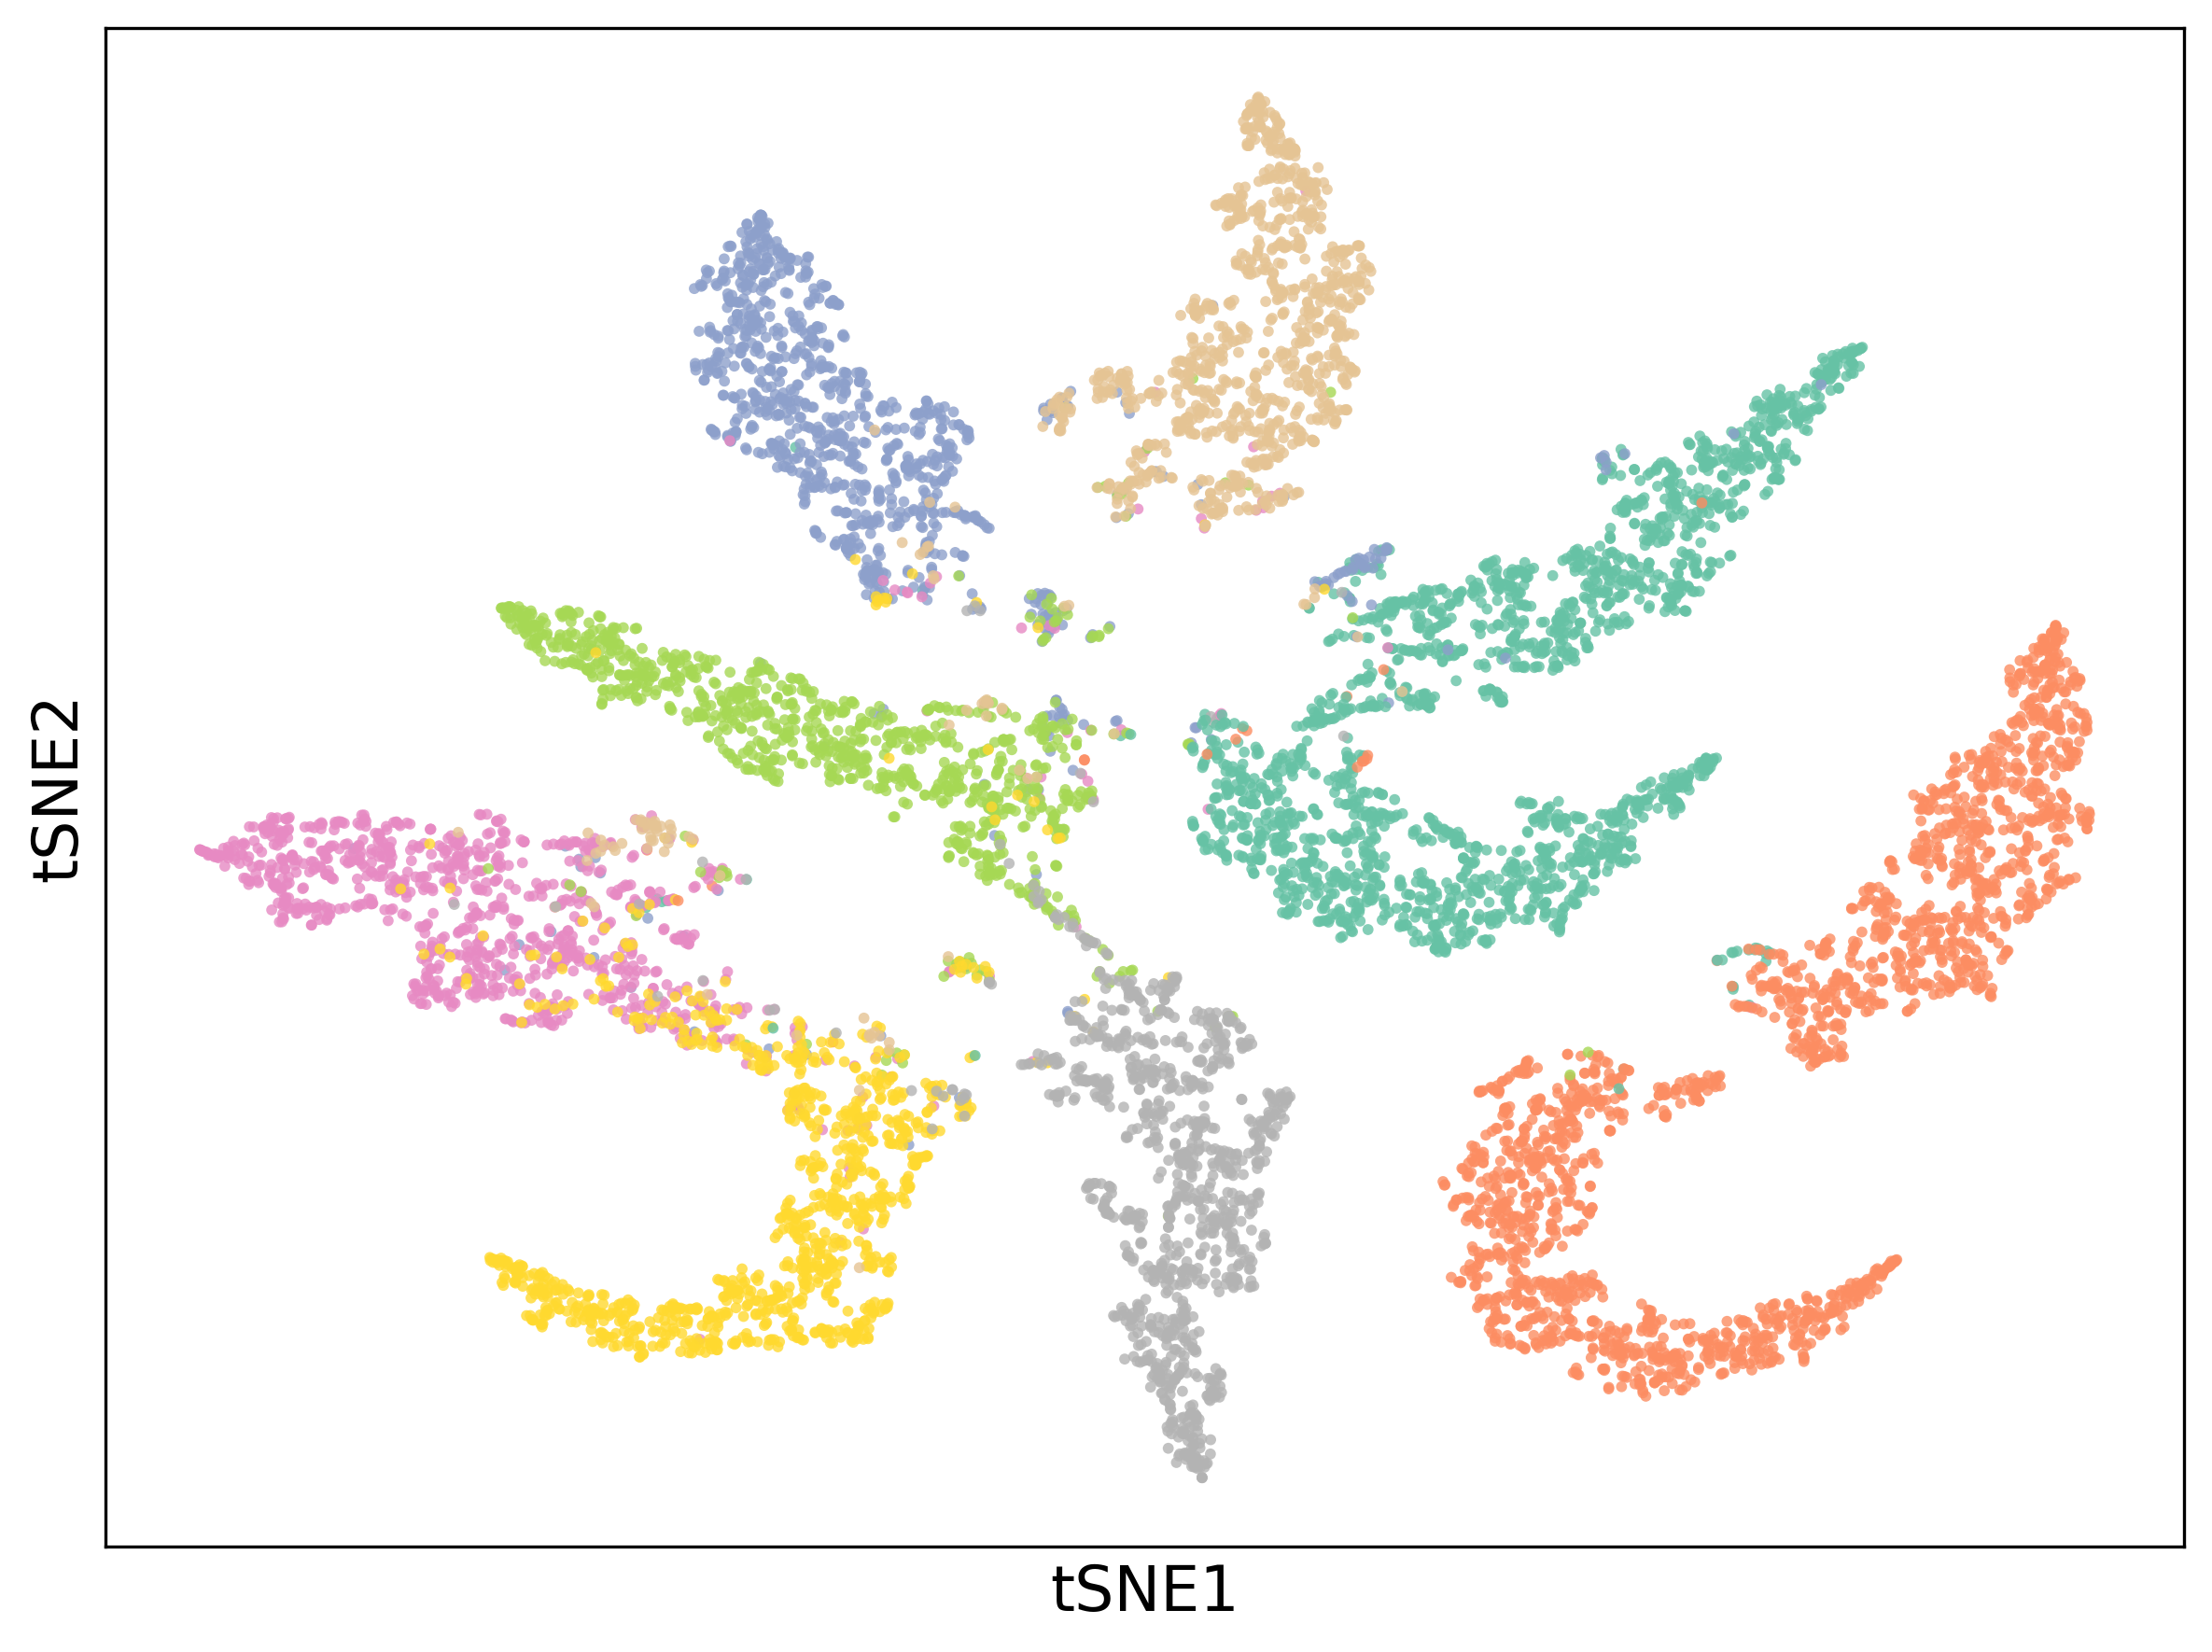

In [ ]:
visualize_tsne_no_legend(AE, test_loader, device)